In [15]:
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
import os
import time
from IPython import display

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


os.listdir('../input')

['data_records_27638.txt',
 'faulty_images.txt',
 'flavours.csv',
 'metadata27368.csv',
 'images27638']

In [2]:
# read metadata

df_meta = pd.read_csv('../input/metadata27368.csv')
#df_meta.head()

In [4]:
# import flavours

df_flav = pd.read_csv('../input/flavours.csv')
#df_flav.head()
df_Sweet = df_flav['Sweet']
df_Sweet.head()

0       NaN
1    0.3333
2    0.3333
3    0.1667
4    0.1667
Name: Sweet, dtype: float64

In [5]:
# import faulty images indexes

file = open("../input/faulty_images.txt", "r")
faul_id = []
for val in file.read().split():
    faul_id.append(int(val)-1)
file.close()
print(len(faul_id),"faulty images")

262 faulty images


In [6]:
# get the unlabeled images indexes

# search for nan values in flavours df
nan_bool = df_flav.isnull().any(axis=1)
nan_id = np.where(nan_bool == True)[0]
print(len(nan_id),'unlabeled images')

4886 unlabeled images


In [7]:
# remove faulty images from unlabeles

f_nan_id = []
for i in faul_id:
    t = np.where(nan_id == i)[0]
    if len(t) != 0:
        f_nan_id.append(t)
nan_id = np.delete(nan_id, f_nan_id)

print(len(nan_id),'true unlabeled images')

4827 true unlabeled images


In [8]:
# Good images !

good_id = np.arange(27638)
good_id = np.delete(good_id, np.union1d(faul_id, nan_id))

print(len(good_id))



22549


In [9]:
# Train and validation split 
train_id, val_id, _, _ = train_test_split(good_id, good_id, test_size=0.2)

print('Train', len(train_id))
print('Val',len(val_id))

Train 18039
Val 4510


In [12]:
# creat a useful dictionary structures

partition = {}
partition['train'] = train_id
partition['validation'] = val_id
partition['faulty'] = faul_id
partition['no_label'] = nan_id

labels = {}
name = {}
image = {}
for i in range(27638):
    
    labels[str(i)] = df_Sweet.iloc[[i]].values[0] # every label is a panda df rows
    
    name[str(i)] = df_meta['name'][i]
    
    im = str(i+1)
    while len(im) < 5 :
        im = '0' + im
    im ='img' + im + '.jpg'
    image[str(i)] = im

In [13]:
# test dictionaries

print(labels['1'])

print(name['1'])

print(image['1'])

0.3333
Filipino BBQ Pork Skewers
img00002.jpg


In [60]:
def encode_label(labels, ID):
    
    out = np.empty((len(ID), 1))
    
    for i, id in enumerate(ID):
        t = labels[str(id)]
        if t < 0.1:
            t = 0
        elif 0.1 < t < 0.3:
            t = 1
        elif 0.3 < t < 0.4:
            t = 2
        elif 0.4 < t < 0.6:
            t = 3
        elif 0.6 < t < 0.8:
            t = 4
        elif 0.8 < t < 0.9:
            t = 5
        else:
            t = 6
            
        out[i] = t
        
    return out

In [30]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=6, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            im = Image.open("../input/images27638/images27638/"+image[str(ID)])
            im = im.resize((224, 224), Image.ANTIALIAS)
            im.load()
            X[i,] = np.asarray(im, dtype=np.uint8 )

            # Store target labels
            t = self.labels[str(ID)]
            if t < 0.1:
                t = 0
            elif 0.1 < t < 0.3:
                t = 1
            elif 0.3 < t < 0.4:
                t = 2
            elif 0.4 < t < 0.6:
                t = 3
            elif 0.6 < t < 0.8:
                t = 4
            elif 0.8 < t < 0.9:
                t = 5
            else:
                t = 6
            
            y[i] = to_categorical(t, num_classes=7)

        return X, y

In [31]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 1s 0us/step


In [32]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [33]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [35]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [36]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=['acc'])


In [37]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):


    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [41]:
# Define batch size.
batch_size = 64
n_epoch = 25
val_size = len(val_id)


# Parameters
params = {'dim': (224, 224),
          'batch_size': batch_size,
          'n_classes': 7,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)


In [39]:
file_dir = '../working//Model'
network_filepath = os.path.join(file_dir, 'best_model.h5')
os.mkdir(file_dir)

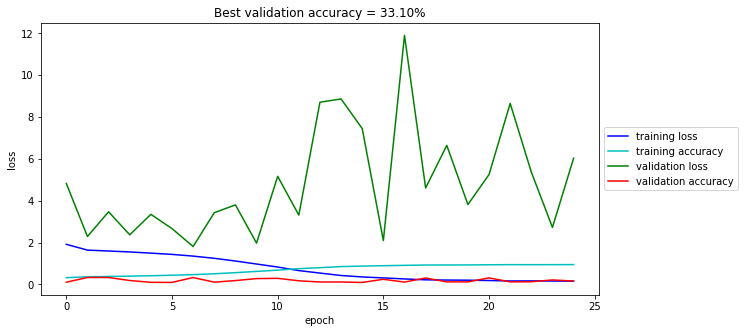

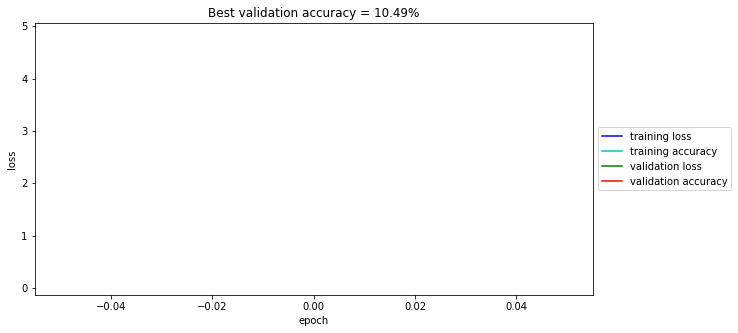

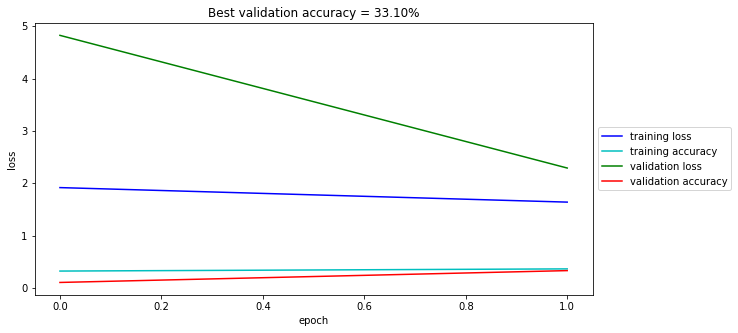

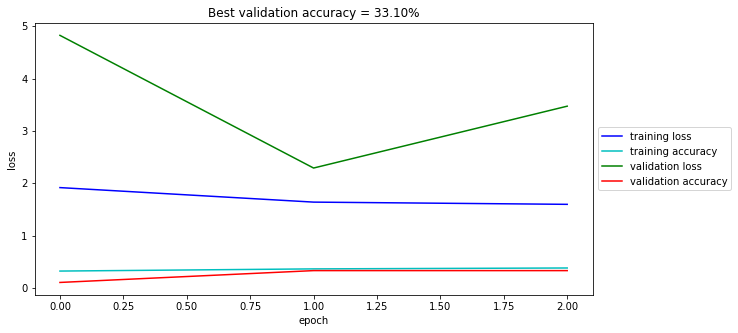

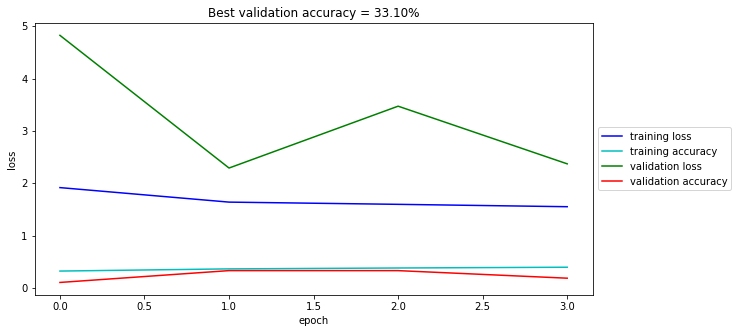

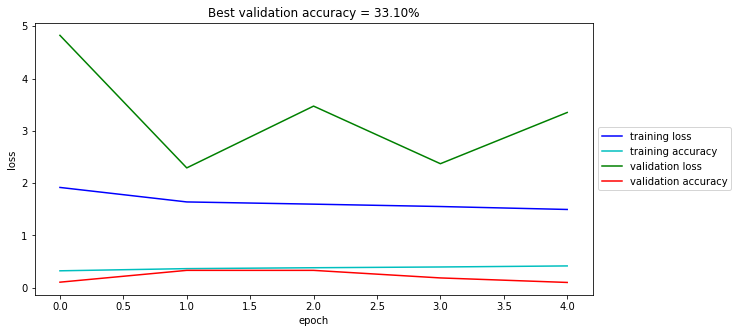

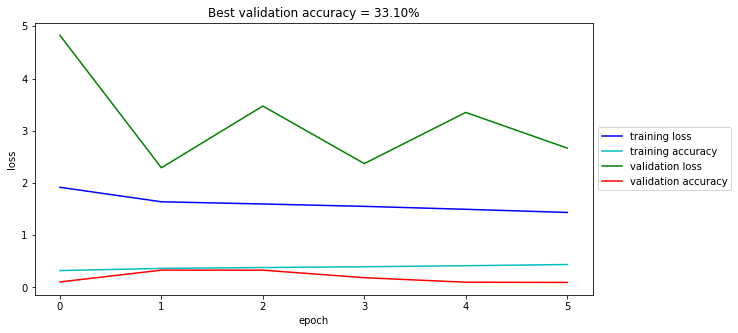

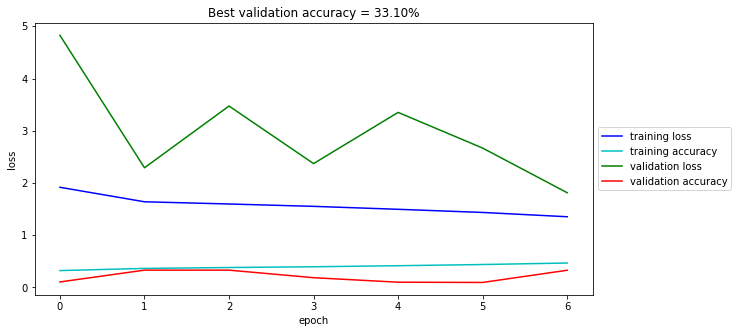

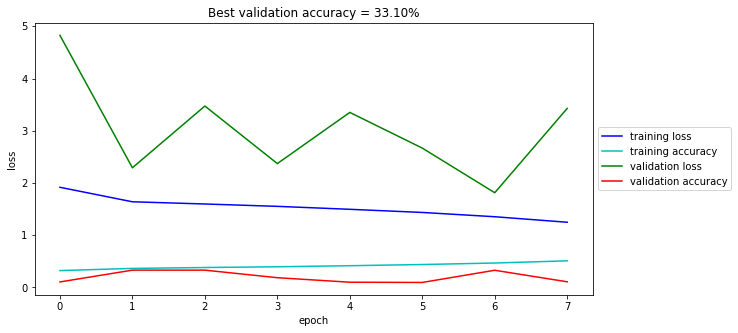

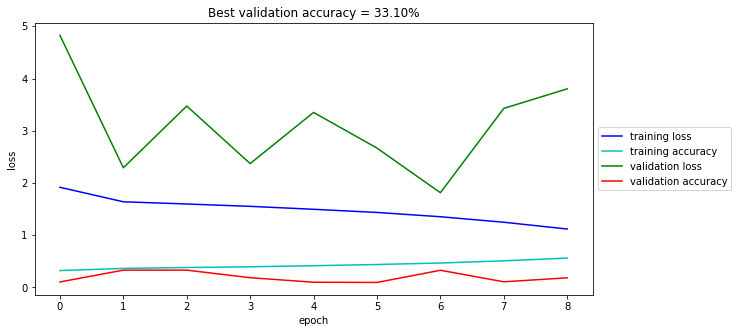

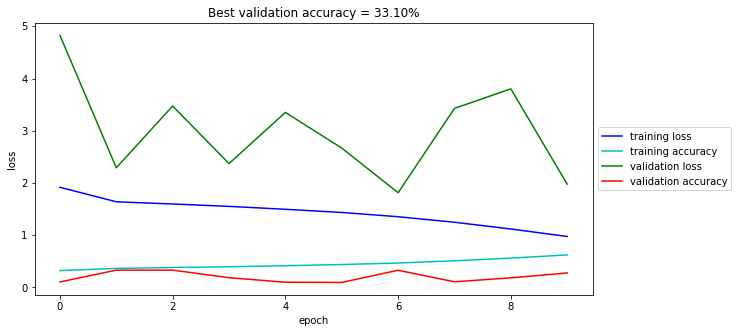

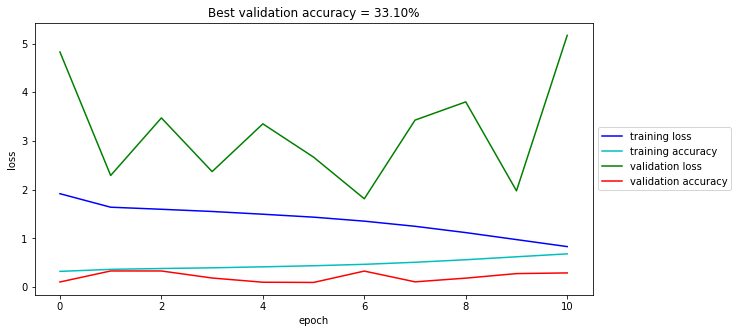

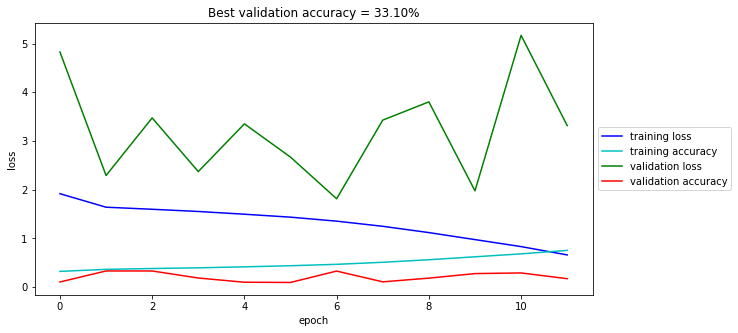

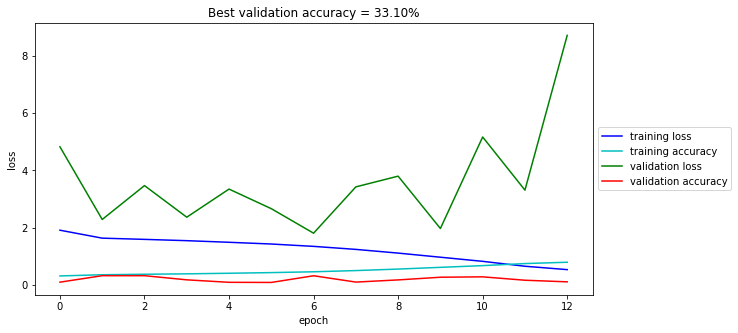

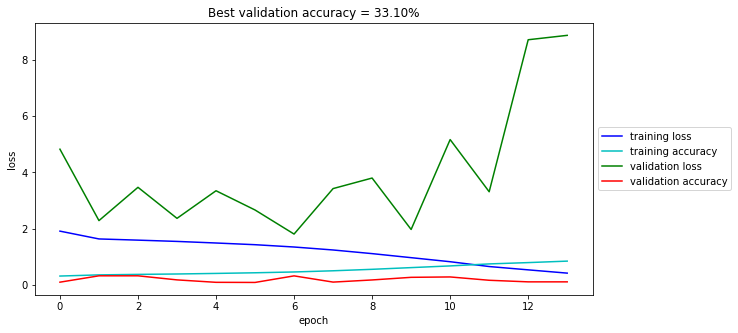

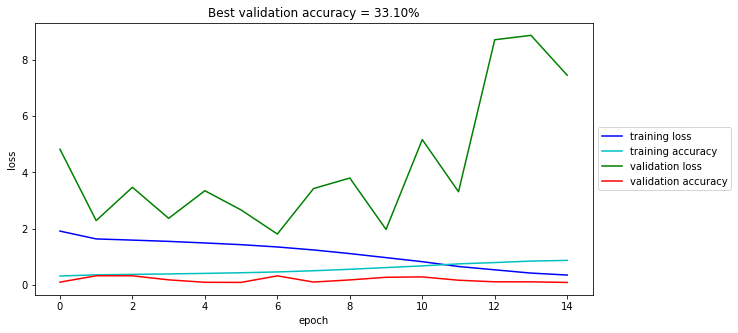

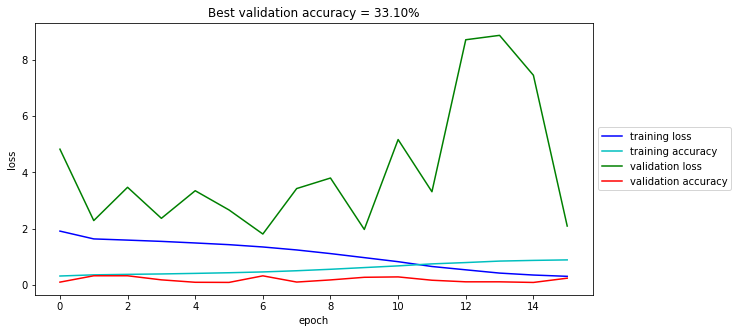

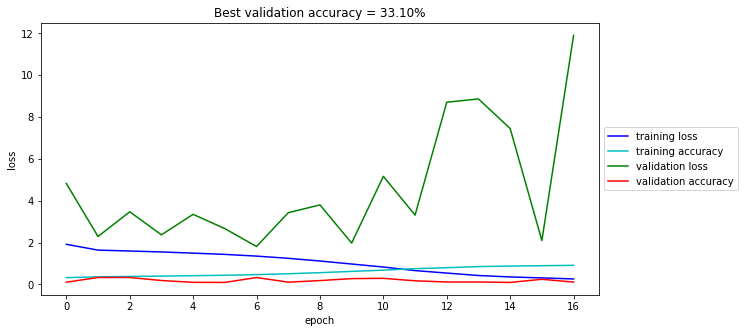

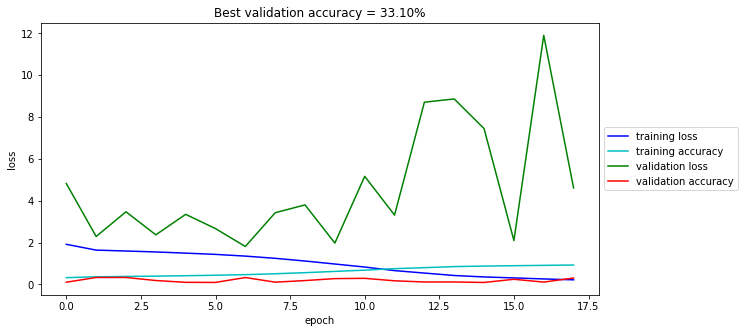

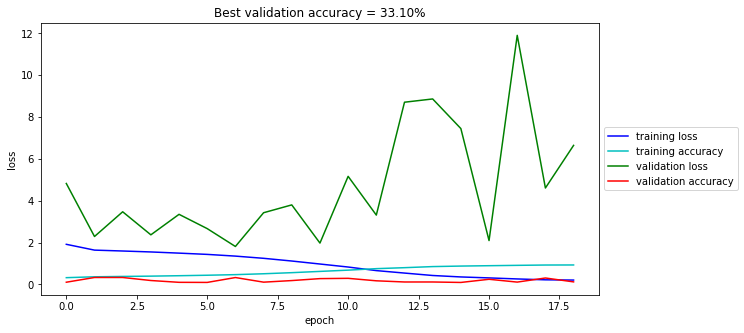

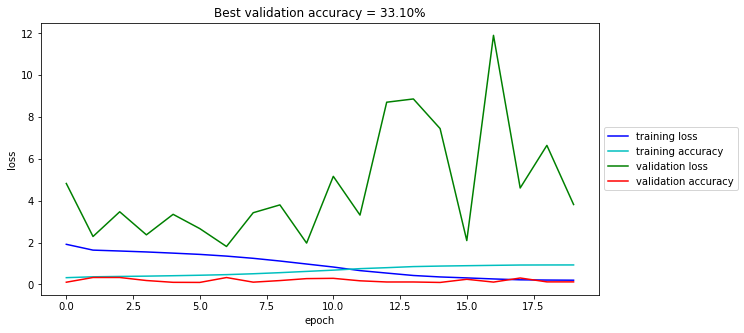

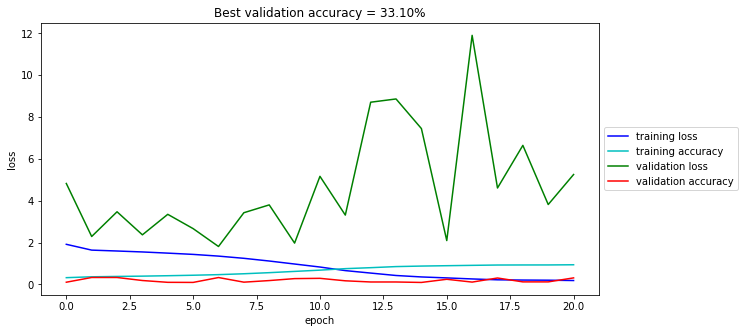

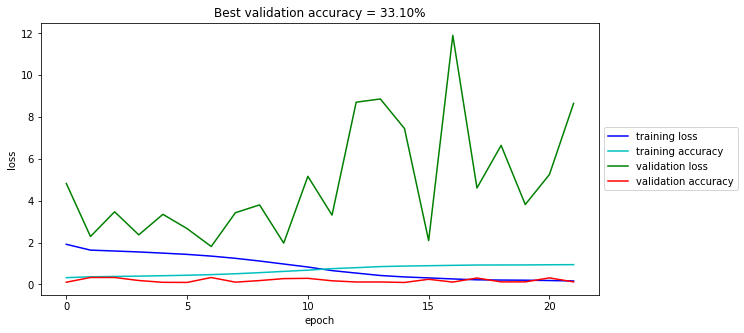

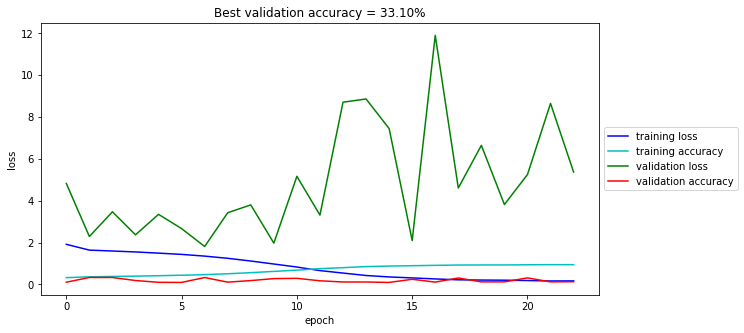

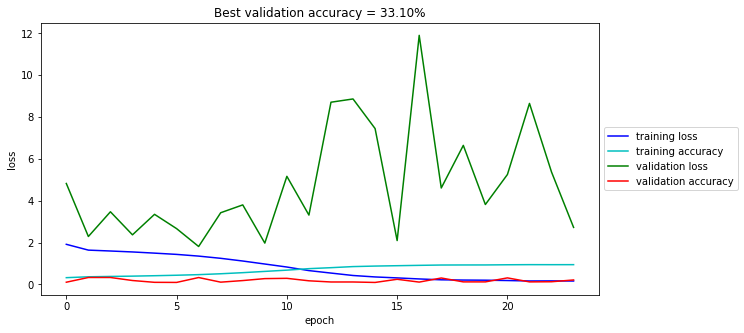

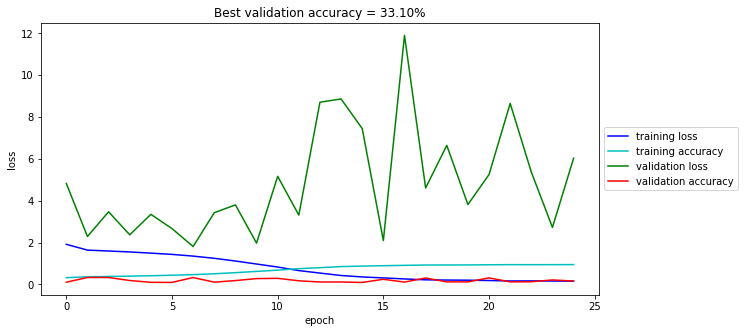

In [42]:
train_network(model, training_generator, validation_generator, n_epoch, network_filepath)

In [43]:
# Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 
best_network=keras.models.load_model(network_filepath)


In [44]:
test = str(val_id[123])

print(name[test])
print(labels[test])
im = Image.open("../input/images27638/images27638/"+image[test])
im = im.resize((224, 224), Image.ANTIALIAS)
im.load()
im = np.asarray(im, dtype=np.uint8 )
im = np.expand_dims(im, axis=0)


pred = best_network.predict(im)
print('Prediction',pred[0])

Chocolate Chip Cookie Dough Brownies
1.0
Prediction [0.01495089 0.878834   0.01849365 0.03479049 0.02418262 0.00569111
 0.02305724]


In [45]:
test = str(val_id[1])

print(name[test])
print(labels[test])
im = Image.open("../input/images27638/images27638/"+image[test])
im = im.resize((224, 224), Image.ANTIALIAS)
im.load()
im = np.asarray(im, dtype=np.uint8 )
im = np.expand_dims(im, axis=0)


pred = best_network.predict(im)
print('Prediction',pred[0])

Chicken Tikka Masala - This is IT!
0.1667
Prediction [0.09195218 0.4984325  0.08448783 0.11228996 0.12761076 0.03413286
 0.05109389]


In [46]:
test = str(val_id[3])

print(name[test])
print(labels[test])
im = Image.open("../input/images27638/images27638/"+image[test])
im = im.resize((224, 224), Image.ANTIALIAS)
im.load()
im = np.asarray(im, dtype=np.uint8 )
im = np.expand_dims(im, axis=0)


pred = best_network.predict(im)
print('Prediction',pred[0])

Roasted Butternut Squash Enchilada Casserole
0.1667
Prediction [0.02010394 0.85544455 0.02863631 0.04166871 0.03402478 0.00628501
 0.01383666]


In [48]:
pred_nan = np.empty((len(nan_id), 7))
pred_name = []
for i, id in enumerate(nan_id):
    test = str(id)
    pred_name.append(name[test])
    im = Image.open("../input/images27638/images27638/"+image[test])
    im = im.resize((224, 224), Image.ANTIALIAS)
    im.load()
    im = np.asarray(im, dtype=np.uint8 )
    im = np.expand_dims(im, axis=0)
    pred = best_network.predict(im)
    pred_nan[i] = pred

In [49]:
print(pred_nan)

[[0.02140522 0.70226079 0.02726098 ... 0.06865142 0.03259224 0.08020461]
 [0.01514646 0.87482959 0.02697701 ... 0.0312716  0.0035327  0.00853925]
 [0.02829798 0.74080372 0.02491377 ... 0.05281604 0.02200708 0.06371359]
 ...
 [0.0756536  0.66834253 0.06208094 ... 0.07453731 0.01195808 0.02306115]
 [0.01307775 0.88255757 0.02561522 ... 0.02922593 0.00416032 0.01025346]
 [0.00988412 0.92994565 0.01660036 ... 0.01304274 0.00178478 0.00561428]]


In [59]:
print(pred_nan[0:50, 6])

[0.08020461 0.00853925 0.06371359 0.00528023 0.02319591 0.0061331
 0.10136244 0.02703823 0.0155473  0.02993085 0.0820213  0.01547709
 0.01066777 0.0095265  0.02127378 0.03427652 0.06917556 0.04120182
 0.01206198 0.0232294  0.03156688 0.02213604 0.02707202 0.05413286
 0.01220706 0.00489059 0.04468483 0.00537206 0.00397258 0.01086734
 0.00534985 0.03285275 0.02449701 0.24808004 0.06534507 0.20058537
 0.06235603 0.01287814 0.07999956 0.02243725 0.05180088 0.00542079
 0.02028518 0.04918487 0.02772018 0.01984967 0.04521292 0.01814197
 0.04366197 0.00330292]


(array([ 695., 7170.,    0., 2790.,    0., 2911., 4014.,    0., 2728.,
        2241.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

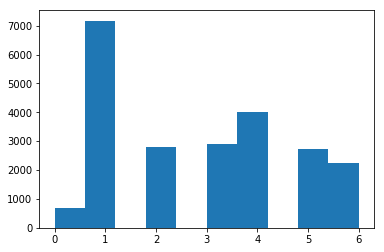

In [61]:
encoded_labels = encode_label(labels, good_id)

plt.hist(encoded_labels)

In [62]:
###very unbalance classes